# Spam Comment Classification



In [1]:
# Importing data analysis packages
import pandas as pd
import numpy as np

# Importing natural language processing packages
import re
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer

# Importing model selection and feature extraction packages
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit, cross_validate, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer

# Importing machine learning packages
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeClassifier, SGDClassifier, PassiveAggressiveClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC 
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# Importing data visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="whitegrid")

# Miscellaneous
import time
import warnings
warnings.filterwarnings('ignore')

---
<a id='section 1.0.'></a>
## 1.0. Data Import


In [2]:
df=pd.read_excel(r'data\Comment Spam.xlsx');
    
# Show the first 5 rows the dataset
print(df)

        No                                            Comment  Class
0        1                                this song is racist      0
1        2  and how many subscribers compared to her over ...      1
2        3  HI! CHECK OUT OUR AWESOME COVERS! AND SAY WHAT...      1
3        4                                  well done shakira      0
4        5                 :D subscribe to me for daily vines      1
...    ...                                                ...    ...
1295  1296                                      Awsome<br />﻿      0
1296  1297                https://www.tsu.co/KodysMan plz ^^﻿      1
1297  1298  Sign up for free on TSU and start making money...      1
1298  1299  MEGAN FOX AND EMINEM TOGETHER IN A VIDEO  DOES...      0
1299  1300                              Great.This is a song﻿      0

[1300 rows x 3 columns]


We only need data from `Comment` and `Class` column. So, we put them in the `comments` and `labels` variable, respectively. 

In [3]:
comments = df['Comment']
labels = df['Class'].values

Let's see the distribution of labels in the dataset.

In [4]:
pd.Series(labels).value_counts()

1    669
0    631
dtype: int64

In [5]:
# Lowercase all words
comments = comments.apply(lambda x: x.lower())

<a id='section 2.2.'></a>
### 2.2. Replace URL


In [6]:
def replace_url(text, replacement):
    text = str(text)
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', replacement, text)
    text = re.sub('[/]?watch(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', replacement, text)
    
    return text

# Replace url to http
comments = comments.apply(lambda x: replace_url(x, 'http'))

<a id='section 2.3.'></a>
### 2.3. Remove Encoding


In [7]:
def remove_encoding(text):
    text = str(text)
    text = text.replace('\ufeff', '')
    return text

# Remove encoding
comments = comments.apply(lambda x: remove_encoding(x))

In [8]:
# tokenize all comments in the data
comments_token = comments.apply(lambda x: x.split())

In [9]:
print('Average word length of comments is {0:.0f}.'.format(np.mean(comments_token.apply(lambda x: len(x)))))
print('Max word length of comments is {0:.0f}.'.format(np.max(comments_token.apply(lambda x: len(x)))))
print('Min word length of comments is {0:.0f}.'.format(np.min(comments_token.apply(lambda x: len(x)))))

Average word length of comments is 16.
Max word length of comments is 213.
Min word length of comments is 1.


<a id='section 3.2.'></a>
### 3.2. Stop Words Removal
  

In [10]:
stop_words=set(stopwords.words('english')) 

comments_rsw=[]
for comment_token in comments_token:
    filtered_comment=[w for w in comment_token if not w in stop_words] 
    comments_rsw.append(filtered_comment)

<a id='section 3.3.'></a>
### 3.3. Lemmatization


In [11]:
def lemmatization(dataset):
    lemma=nltk.WordNetLemmatizer()
    comments_lemma=[]
    for comment in comments_rsw:
        comment_lemma=[lemma.lemmatize(w) for w in comment]
        comments_lemma.append(comment_lemma)
    return comments_lemma

# Words lemmatization
comments_lemma=lemmatization(comments_rsw)

<a id='section 3.4.'></a>
### 3.4. Train and Test Set Split


In [12]:
X_train, X_test, y_train, y_test = train_test_split(comments_lemma, 
                                                    labels, 
                                                    test_size=0.2, 
                                                    shuffle=True, 
                                                    random_state=0, 
                                                    stratify=labels)

<a id='section 3.5.'></a>
### 3.5. Create Bag of Words


In [13]:
# Create bag of words

X_train_untokenized = []

for comment in X_train:
    text = ' '.join(comment)
    X_train_untokenized.append(text)
    
vect = CountVectorizer(min_df=3)
vect.fit(X_train_untokenized)


X_test_untokenized = []

for comment in X_test:
    text = ' '.join(comment)
    X_test_untokenized.append(text)

X_train = vect.transform(X_train_untokenized).toarray()
X_test = vect.transform(X_test_untokenized).toarray()

---
<a id='section 4.0.'></a>
## 4.0. Define Models


<a id='section 4.1.'></a>
### 4.1. Simple Modelling


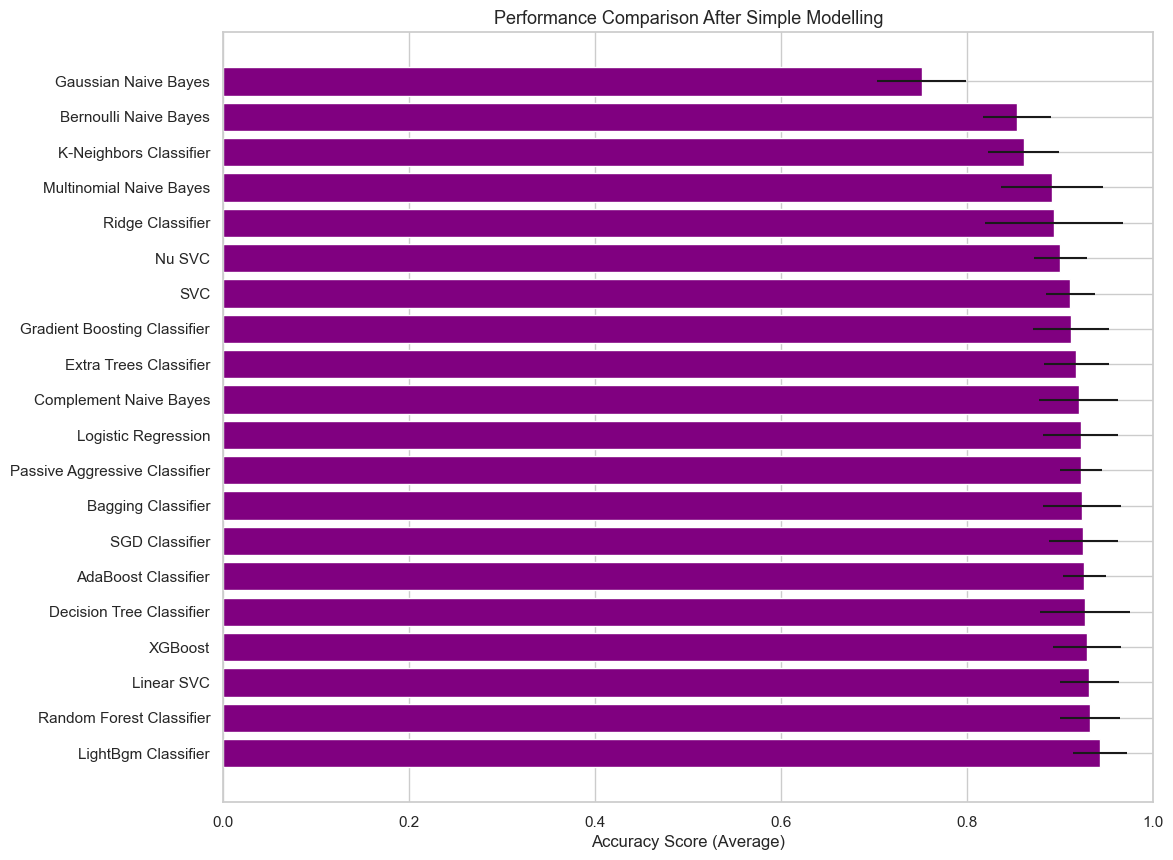

In [14]:
# List of machine learning algorithms that will be used for predictions
estimator = [('Logistic Regression', LogisticRegression), ('Ridge Classifier', RidgeClassifier), 
             ('SGD Classifier', SGDClassifier), ('Passive Aggressive Classifier', PassiveAggressiveClassifier), 
             ('SVC', SVC), ('Linear SVC', LinearSVC), ('Nu SVC', NuSVC), 
             ('K-Neighbors Classifier', KNeighborsClassifier),
             ('Extra Trees Classifier',LGBMClassifier),
             ('Gaussian Naive Bayes', GaussianNB), ('Multinomial Naive Bayes', MultinomialNB), 
             ('Bernoulli Naive Bayes', BernoulliNB), ('Complement Naive Bayes', ComplementNB), 
             ('Decision Tree Classifier', DecisionTreeClassifier), 
             ('Random Forest Classifier', RandomForestClassifier), ('AdaBoost Classifier', AdaBoostClassifier), 
             ('Gradient Boosting Classifier', GradientBoostingClassifier), ('Bagging Classifier', BaggingClassifier), 
             ('LightBgm Classifier', ExtraTreesClassifier), ('XGBoost', XGBClassifier)]

# Creating a dataframe to compare the performance of the machine learning models
comparison_cols = ['Algorithm', 'Training Time (Avg)', 'Accuracy (Avg)', 'Accuracy (3xSTD)']
comparison_df = pd.DataFrame(columns=comparison_cols)

# Generating training/validation dataset splits for cross validation
cv_split = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=0)

# Performing cross-validation to estimate the performance of the models
for idx, est in enumerate(estimator):
    
    cv_results = cross_validate(est[1](), X_train, y_train, cv=cv_split)
    
    comparison_df.loc[idx, 'Algorithm'] = est[0]
    comparison_df.loc[idx, 'Training Time (Avg)'] = cv_results['fit_time'].mean()
    comparison_df.loc[idx, 'Accuracy (Avg)'] = cv_results['test_score'].mean()
    comparison_df.loc[idx, 'Accuracy (3xSTD)'] = cv_results['test_score'].std() * 3

comparison_df.set_index(keys='Algorithm', inplace=True)
comparison_df.sort_values(by='Accuracy (Avg)', ascending=False, inplace=True)

#Visualizing the performance of the models
fig, ax = plt.subplots(figsize=(12,10))

y_pos = np.arange(len(comparison_df))
ax.barh(y_pos, comparison_df['Accuracy (Avg)'], xerr=comparison_df['Accuracy (3xSTD)'], color='purple')
ax.set_yticks(y_pos)
ax.set_yticklabels(comparison_df.index)
ax.set_xlabel('Accuracy Score (Average)')
ax.set_title('Performance Comparison After Simple Modelling', size=13)
ax.set_xlim(0, 1)

plt.show()

<a id='section 4.2.'></a>
### 4.2. Hyperparameter Optimization for the Best Models


In [15]:
# A list of machine learning algorithms that will be optimized
estimator = [('LightBgm Classifier', ExtraTreesClassifier), 
             ('Linear SVC', LinearSVC), ('Bagging Classifier', BaggingClassifier),
             ('Gradient Boosting Classifier', GradientBoostingClassifier),
             ('Extra Trees Classifier',LGBMClassifier),
             ('AdaBoost Classifier', AdaBoostClassifier),
             ('Random Forest Classifier', RandomForestClassifier),
             ('Logistic Regression', LogisticRegression),  
             ('Passive Aggressive Classifier', PassiveAggressiveClassifier)]

index = [est[0] for est in estimator]

# A dictionary containing hyperparameters that are to be optimized for each machine learning algorithm
grid_params = {'SVC': {'C': np.arange(1,21,1), 'gamma': [0.005, 0.01, 0.015, 0.02], 'random_state': [0]},
               'Ridge Classifier': {'alpha': [0.001, 0.0025, 0.005], 'random_state': [0]},
               'Nu SVC': {'nu': [0.5], 'gamma': [0.001, 0.01, 0.1, 1], 'random_state': [0]},
               'Gradient Boosting Classifier': {'learning_rate': [0.001, 0.005, 0.01, 0.015], 'random_state': [0],
                                                'max_depth': [1,2,3,4,5], 'n_estimators': [300, 350, 400, 450, 500]},
               'Extra Trees Classifier': {'learning_rate': [0.001, 0.005, 0.01, 0.015], 'random_state': [0],
                                                'max_depth': [1,2,3,4,5], 'n_estimators': [300, 350, 400, 450, 500]},
               'Linear SVC': {'C': [1, 5, 10], 'random_state': [0]},
               'Logistic Regression': {'C': np.arange(2,7.5,0.25), 
                                       'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
                                       'random_state': [0]},
               'AdaBoost Classifier': {'learning_rate': np.arange(0.05, 0.21, 0.01), 'n_estimators': [50, 75, 100, 125, 150], 
                                       'random_state': [0]},
               'Random Forest Classifier': {'n_estimators': [200, 250, 300, 350], 'max_depth': [1,2,3,4,5,6], 
                                            'criterion': ['gini', 'entropy'], 'random_state': [0]},
               'Bagging Classifier': {'n_estimators': np.arange(200, 300, 10), 'random_state': [0]},
               'XGBoost': {'learning_rate': [0.001, 0.005, 0.01, 0.015], 'random_state': [0],
                           'max_depth': [1,2,3,4,5], 'n_estimators': [300, 350, 400, 450, 500]},
               'LightBgm Classifier': {'n_estimators': [10, 20, 50, 100], 'criterion': ['gini', 'entropy'],
                                          'random_state': [0]},
               'Passive Aggressive Classifier': {'C': np.arange(1,21,1)}
              }

# Creating a dataframe to compare the performance of the machine learning models after hyperparameter optimization 
best_params_df = pd.DataFrame(columns=['Optimized Hyperparameters', 'Accuracy'], index=index)

# Performing grid-search cross-validation to optimize hyperparameters and estimate the performance of the models
for idx, est in enumerate(estimator):
    
    best_clf = GridSearchCV(est[1](), param_grid=grid_params[est[0]], cv=cv_split, scoring='accuracy', n_jobs=12)
    best_clf.fit(X_train, y_train)
    
    best_params_df.loc[est[0], 'Optimized Hyperparameters'] = [best_clf.best_params_]
    best_params_df.loc[est[0], 'Accuracy'] = best_clf.best_score_
    

In [16]:
# Showing the results of grid-search cross-validation
best_params_df.sort_values('Accuracy')

,Optimized Hyperparameters,Accuracy
Random Forest Classifier,"[{'criterion': 'entropy', 'max_depth': 1, 'n_e...",0.879487
Extra Trees Classifier,"[{'learning_rate': 0.015, 'max_depth': 5, 'n_e...",0.913782
Gradient Boosting Classifier,"[{'learning_rate': 0.015, 'max_depth': 5, 'n_e...",0.924038
Passive Aggressive Classifier,[{'C': 18}],0.926603
Bagging Classifier,"[{'n_estimators': 200, 'random_state': 0}]",0.928205
Linear SVC,"[{'C': 1, 'random_state': 0}]",0.93109
AdaBoost Classifier,"[{'learning_rate': 0.19, 'n_estimators': 125, ...",0.931731
Logistic Regression,"[{'C': 7.0, 'random_state': 0, 'solver': 'libl...",0.934295
LightBgm Classifier,"[{'criterion': 'entropy', 'n_estimators': 100,...",0.94391


In [21]:
best_params_df.loc['LightBgm Classifier', 'Optimized Hyperparameters']

[{'criterion': 'entropy', 'n_estimators': 100, 'random_state': 0}]

---
<a id='section 5.0.'></a>
## 5.0. Prediction


In [29]:
from sklearn.metrics import accuracy_score

clf = ExtraTreesClassifier(criterion = 'gini',
                           n_estimators = 100,
                           random_state = 0)

clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

print('The accuracy of the model based on the test set: {}'.format(accuracy_score(y_test, predictions)))

The accuracy of the model based on the test set: 0.9423076923076923


In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('The precision of the model based on the test set: {}'.format(precision_score(y_test, predictions)))
print('The recall of the model based on the test set: {}'.format(recall_score(y_test, predictions)))
print('The F1 score of the model based on the test set: {}'.format(f1_score(y_test, predictions)))

The precision of the model based on the test set: 0.9541984732824428
The recall of the model based on the test set: 0.9328358208955224
The F1 score of the model based on the test set: 0.9433962264150944
